In [ ]:
import numpy as np
import torch
from torch.optim import Optimizer


class PGD(Optimizer):
    """
    Projected Gradient Descent optimiser.
    
    :param projector: projetor function object. If None, than will be used     
    """
    def __init__(self, parameters, projector=None, lr=None):
        if lr is not None and lr < 0.0:
            raise ValueError("Invalid learning rate: {} - should be >= 0.0".format(lr))
        defaults = {"lr": lr, "projector": projector}
        super().__init__(parameters, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure
           
        for group in self.param_groups:
            for p in group['params']:
                
        return loss
    
    @staticmethod
    def project_simplex(x, mask=None):
        """ Take a vector x (with possible nonnegative entries and non-normalized)
            and project it onto the unit simplex.
        """
        xsorted = torch.sort(x)[::-1]
        # entries need to sum up to 1 (unit simplex)
        sum_ = 1.0
        astar = -1
        lambda_a = (torch.cumsum(xsorted) - sum_) / torch.arange(1.0, len(xsorted)+1.0)
        for i in range(len(lambda_a)-1):
            if lambda_a[i] >= xsorted[i+1]:
                astar = i
                break
        p = torch.maximum(x-lambda_a[astar],  0)
        return p        

In [1]:
import numpy as np
import torch
from torch.optim import Optimizer


class PGD(Optimizer):
    """Take a coordinate descent step for a random parameter.
    And also, make every 100th step way bigger.
    """
    def __init__(self, parameters, lr=None):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {} - should be >= 0.0".format(lr))
        defaults = {"lr": lr}
        super().__init__(parameters, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure
           
        for group in self.param_groups:
            for p in group['params']:
                x_k = p.data
                f_k = loss(x_k)
                proj_x_k = PGD.project_simplex(x_k)
                y = proj_x_k
                grad_k = p.grad.data
                
                if group['lr'] is not None:
                    lr_k = group['lr']
                else:
                    lr_k = 1 / torch.norm(grad_k)
                    
                self.zero_grad()
                f = loss(proj_x_k)
                loss.backward()
                grad_ = p.grad.data
                
                while True:
                    y_new = project(y.add(grad_, alpha=-lr_k))
                    self.zero_grad()
                    f_new = loss(y_new)
                    loss.backward()
                    grad_new = p.grad.data
                    if f_new < f + torch.mm(y_new - y, grad.T) + (1 / 2*lr_k) * torch.norm(y_new - y)**2:
                        break
                    lr_k *= 0.8
                lr_k /= 3    
                    
                z = project(proj_x_k.add(grad_x_k, alpha=-lr_k))
                fnew, gradnew = loss(z, *args)
                while fnew > f + np.dot(z - p, grad.T) + \
                    0.5 * np.linalg.norm(z - p)**2 / s:
                    s *= 0.5
                    z = mproject(p - s * grad)
                    fnew, gradnew = mfun(z, *args)
                p = z
                f, grad = fnew, gradnew
                
                p.data = project(proejected_data.add(gradient, alpha=-group['lr']))
                group['lr'].mul_(0.5)
        return loss
    
    @staticmethod
    def project_simplex(x, mask=None):
        """ Take a vector x (with possible nonnegative entries and non-normalized)
            and project it onto the unit simplex.
        """
        xsorted = torch.sort(x)[::-1]
        # entries need to sum up to 1 (unit simplex)
        sum_ = 1.0
        astar = -1
        lambda_a = (torch.cumsum(xsorted) - sum_) / torch.arange(1.0, len(xsorted)+1.0)
        for i in range(len(lambda_a)-1):
            if lambda_a[i] >= xsorted[i+1]:
                astar = i
                break
        p = torch.maximum(x-lambda_a[astar],  0)
        return p        

In [3]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim import Adam, SGD
from tqdm import tqdm

def rosenbrock(xy):
    """Evaluate Rosenbrock function.
    Parameters
    ----------
    xy : tuple
        Two element tuple of floats representing the x resp. y coordinates.
    Returns
    -------
    float
        The Rosenbrock function evaluated at the point `xy`.
    """
    x, y = xy

    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

def run_optimization(xy_init, optimizer_class, n_iter, **optimizer_kwargs):
    """Run optimization finding the minimum of the Rosenbrock function.
    Parameters
    ----------
    xy_init : tuple
        Two floats representing the x resp. y coordinates.
    optimizer_class : object
        Optimizer class.
    n_iter : int
        Number of iterations to run the optimization for.
    optimizer_kwargs : dict
        Additional parameters to be passed into the optimizer.
    Returns
    -------
    path : np.ndarray
        2D array of shape `(n_iter + 1, 2)`. Where the rows represent the
        iteration and the columns represent the x resp. y coordinates.
    """
    xy_t = torch.tensor(xy_init, requires_grad=True)
    optimizer = optimizer_class([xy_t], **optimizer_kwargs)

    path = np.empty((n_iter + 1, 2))
    path[0, :] = xy_init

    for i in tqdm(range(1, n_iter + 1)):
        optimizer.zero_grad()
        loss = rosenbrock(xy_t)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(xy_t, 1.0)
        optimizer.step()

        path[i, :] = xy_t.detach().numpy()

    return path

def create_animation(paths,
                     colors,
                     names,
                     figsize=(12, 12),
                     x_lim=(-2, 2),
                     y_lim=(-1, 3),
                     n_seconds=5):
    """Create an animation.
    Parameters
    ----------
    paths : list
        List of arrays representing the paths (history of x,y coordinates) the
        optimizer went through.
    colors :  list
        List of strings representing colors for each path.
    names : list
        List of strings representing names for each path.
    figsize : tuple
        Size of the figure.
    x_lim, y_lim : tuple
        Range of the x resp. y axis.
    n_seconds : int
        Number of seconds the animation should last.
    Returns
    -------
    anim : FuncAnimation
        Animation of the paths of all the optimizers.
    """
    if not (len(paths) == len(colors) == len(names)):
        raise ValueError

    path_length = max(len(path) for path in paths)

    n_points = 300
    x = np.linspace(*x_lim, n_points)
    y = np.linspace(*y_lim, n_points)
    X, Y = np.meshgrid(x, y)
    Z = rosenbrock([X, Y])

    minimum = (1.0, 1.0)

    fig, ax = plt.subplots(figsize=figsize)
    ax.contour(X, Y, Z, 90, cmap="jet")

    scatters = [ax.scatter(None,
                           None,
                           label=label,
                           c=c) for c, label in zip(colors, names)]

    ax.legend(prop={"size": 25})
    ax.plot(*minimum, "rD")

    def animate(i):
        for path, scatter in zip(paths, scatters):
            scatter.set_offsets(path[:i, :])

        ax.set_title(str(i))

    ms_per_frame = 1000 * n_seconds / path_length

    anim = FuncAnimation(fig, animate, frames=path_length, interval=ms_per_frame)

    return anim

  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]<ipython-input-1-82624ce6cddf>:27: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\python_arg_parser.cpp:1055.)
  p.data.add_(-group['lr'], d_p)
  5%|███▋                                                                           | 70/1500 [00:00<00:02, 629.59it/s]

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


 13%|██████████▎                                                                   | 199/1500 [00:00<00:02, 607.40it/s]

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


 22%|████████████████▊                                                             | 324/1500 [00:00<00:02, 581.20it/s]

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


 26%|████████████████████                                                          | 385/1500 [00:00<00:01, 580.34it/s]

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


 34%|██████████████████████████▋                                                   | 513/1500 [00:00<00:01, 584.02it/s]

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


 43%|█████████████████████████████████▏                                            | 638/1500 [00:01<00:01, 583.88it/s]

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


 53%|█████████████████████████████████████████▎                                    | 795/1500 [00:01<00:01, 687.11it/s]

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


 59%|██████████████████████████████████████████████▍                               | 892/1500 [00:01<00:00, 744.07it/s]

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


 70%|█████████████████████████████████████████████████████▌                       | 1043/1500 [00:01<00:00, 729.49it/s]

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


 80%|█████████████████████████████████████████████████████████████▎               | 1195/1500 [00:01<00:00, 737.14it/s]

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


 92%|██████████████████████████████████████████████████████████████████████▍      | 1373/1500 [00:02<00:00, 799.01it/s]

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:02<00:00, 692.30it/s]


{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


KeyboardInterrupt: 

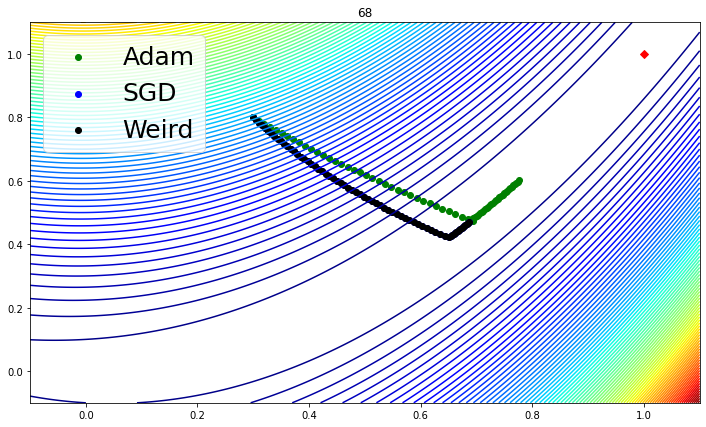

In [4]:
xy_init = (.3, .8)
n_iter = 1500

path_adam = run_optimization(xy_init, Adam, n_iter)
path_sgd = run_optimization(xy_init, SGD, n_iter, lr=1e-3)
path_weird = run_optimization(xy_init, PGD, n_iter, lr=1e-3)

freq = 10

paths = [path_adam[::freq], path_sgd[::freq], path_weird[::freq]]
colors = ["green", "blue", "black"]
names = ["Adam", "SGD", "Weird"]

anim = create_animation(paths,
                        colors,
                        names,
                        figsize=(12, 7),
                        x_lim=(-.1, 1.1),
                        y_lim=(-.1, 1.1),
                        n_seconds=7)

anim.save("result.gif")
print(path_weird[-15:])

In [5]:
import numpy as np


def project_simplex(x, mask=None):
    """ Take a vector x (with possible nonnegative entries and non-normalized)
        and project it onto the unit simplex.
        mask:   do not project these entries
                project remaining entries onto lower dimensional simplex
    """
    if mask is not None:
        mask = np.asarray(mask)
        xsorted = np.sort(x[~mask])[::-1]
        # remaining entries need to sum up to 1 - sum x[mask]
        sum_ = 1.0 - np.sum(x[mask])
    else:
        xsorted = np.sort(x)[::-1]
        # entries need to sum up to 1 (unit simplex)
        sum_ = 1.0
    lambda_a = (np.cumsum(xsorted) - sum_) / np.arange(1.0, len(xsorted)+1.0)
    for i in range(len(lambda_a)-1):
        if lambda_a[i] >= xsorted[i+1]:
            astar = i
            break
    else:
        astar = -1
    p = np.maximum(x-lambda_a[astar],  0)
    if mask is not None:
        p[mask] = x[mask]
    return p



class OptimizeResult(dict):
    """ Represents the optimization result.
    Parameters
    ----------
    x : ndarray
        the solution of the optimization.
    success : bool
        whether or not the optimizer exited successfully.
    status : int
        termination status of the optimizer. its value depends on the
        underlying solver. refer to `message` for details.
    message : str
        description of the cause of the termination.
    fun, jac, hess, hess_inv : ndarray
        values of objective function, jacobian, hessian or its inverse (if
        available). the hessians may be approximations, see the documentation
        of the function in question.
    nfev, njev, nhev : int
        Number of evaluations of the objective functions and of its
        Jacobian and Hessian.
    nit : int
        Number of iterations performed by the optimizer.
    maxcv : float
        The maximum constraint violation.
    Notes
    -----
    There may be additional attributes not listed above depending of the
    specific solver. Since this class is essentially a subclass of dict
    with attribute accessors, one can see which attributes are available
    using the `keys()` method.
    """
    def __getattr__(self, name):
        try:
            return self[name]
        except KeyError:
            raise AttributeError(name)

    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __repr__(self):
        if self.keys():
            m = max(map(len, list(self.keys()))) + 1
            return '\n'.join([k.rjust(m) + ': ' + repr(v)
                              for k, v in self.items()])
        else:
            return self.__class__.__name__ + "()"

def minimize(fun, x0, args=(),
             project=project_simplex,
             nboundupdate=100,
             reltol=1e-4, abstol=0.0, maxiters=1e7,
             algo='fast',
             disp=False,
             callback=None,
             mask=None):
    """
    minimize     fun(x)
    subject to constraints on x expressed through a projection
    parameters
    ----------
    fun : function returning cost, gradient
    x0 : starting guess
    args: Extra arguments passed to the objective function
    project : projection operator (default: projection onto probability simplex)
    nboundupdate : number of iteration between lower bound updates
    reltol, abstol, maxiters: numerical parameter
    algo: fast or normal algorithm
    disp: print status information during the run
    mask: Boolean array with directions along which not to optimize
    callback: callback function called as callback(f, p)
    output
    ------
    Optimal solution as `OptimizeResult` object. Parameters include 
    x : ndarray
        The solution of the optimization.
    fun : ndarray
        value of objective function
    """

    if mask is not None:
        mask = np.asarray(mask)

        def mfun(x, *args):
            f, grad = fun(x, *args)
            if grad is not None:
                grad[mask] = 0.0
            return f, grad
        mfun = mfun
        mproject = lambda p: project(p, mask)
    else:
        mfun = fun
        mproject = project
    # initialize p from function input
    p = mproject(np.asarray(x0))
    # counting variable for number of iterations
    k = 0
    # lower bound for the cost function
    low = -np.inf

    # setup for accelerated algorithm
    if algo == 'fast':
        y = p
        f, grad = mfun(p, *args)
        # starting guess for gradient scaling parameter 1 / | nabla f |
        s = 1.0 / np.linalg.norm(grad)
        # refine by backtracking search
        while True:
            y_new = mproject(y - s * grad)
            # abs important as values close to machine precision
            # might become negative in fft convolution screwing
            # up cost calculations
            f_new, grad_new = mfun(y_new, *args)
            if f_new < f + np.dot(y_new - y, grad.T) + \
                    0.5 * np.linalg.norm(y_new - y)**2 / s:
                break
            s *= 0.8
        # reduce s by some factor as optimal s might become smaller during
        # the course of optimization
        s /= 3.0
    else:
        f, grad = mfun(p, *args)

    while k < maxiters:
        k += 1

        # update lower bound on cost function
        # initialize at beginning (k=1) and then every nboundupdateth iteration
        if (k % nboundupdate == 0) or (k == 1):
            if algo =='fast':
                f, grad = mfun(p, *args)
            if mask is not None:
                i = np.argmin(grad[~mask])
                low = max((low, f - np.sum(p * grad) + grad[~mask][i]))
            else:
                i = np.argmin(grad)
                low = max((low, f - np.sum(p * grad) + grad[i]))
            gap = f - low
            if callback:
                callback(f, p)
            if disp:
                print('%g: f %e, gap %e, relgap %e' % (k, f, gap, gap/low if low > 0 else np.inf))
            if ((low > 0 and gap/low < reltol) or gap < abstol):
                if disp:
                    print('stopping criterion reached')
                break

        if algo == 'fast':
            f, grad = mfun(y, *args)
            p, pold = mproject(y - s * grad), p
            y = p + k/(k+3.0) * (p - pold)
        else:
            # see e.g section 4.2 in http://www.web.stanford.edu/~boyd/papers/pdf/prox_algs.pdf
            s = 1.0 / np.linalg.norm(grad)
            z = mproject(p - s * grad)
            fnew, gradnew = mfun(z, *args)
            while fnew > f + np.dot(z - p, grad.T) + \
                    0.5 * np.linalg.norm(z - p)**2 / s:
                s *= 0.5
                z = mproject(p - s * grad)
                fnew, gradnew = mfun(z, *args)
            p = z
            f, grad = fnew, gradnew
    else:
        print('warning: maxiters reached before convergence')
    if disp:
        print('cost %e, low %e, gap %e' % (f, low, gap))

    return OptimizeResult(x=p, fun=f, nit=k, success=True)

In [7]:
import numpy as np
import numpy.testing as npt

def test_basic():

    def objective(x):
        f = np.sum(x**2)
        grad = 2 * x
        return f, grad
    res = minimize(objective, [0.1, 0.7, 0.2], reltol=1e-8)
    npt.assert_allclose(res.x, np.ones(3)/3.0)
    
npt.run_module_suite()

AssertionError: 